<center>
<img src="https://habrastorage.org/web/677/8e1/337/6778e1337c3d4b159d7e99df94227cb2.jpg"/>
## Специализация "Машинное обучение и анализ данных"
<center>Автор материала: программист-исследователь Mail.Ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ [Юрий Кашницкий](https://yorko.github.io/)

# <center> Capstone проект №1 <br> Идентификация пользователей по посещенным веб-страницам
<img src='http://i.istockimg.com/file_thumbview_approve/21546327/5/stock-illustration-21546327-identification-de-l-utilisateur.jpg'>

# <center>Неделя 5.  Соревнование Kaggle "Catch Me If You Can"

На этой неделе мы вспомним про концепцию стохастического градиентного спуска и опробуем классификатор Scikit-learn SGDClassifier, который работает намного быстрее на больших выборках, чем алгоритмы, которые мы тестировали на 4 неделе. Также мы познакомимся с данными [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) Kaggle по идентификации пользователей и сделаем в нем первые посылки. По итогам этой недели дополнительные баллы получат те, кто попадет в топ-30 публичного лидерборда соревнования.

**В этой части проекта Вам могут быть полезны видеозаписи следующих лекций курса "Обучение на размеченных данных":**
   - [Стохатический градиентный спуск](https://www.coursera.org/learn/supervised-learning/lecture/xRY50/stokhastichieskii-ghradiientnyi-spusk)
   - [Линейные модели. Sklearn.linear_model. Классификация](https://www.coursera.org/learn/supervised-learning/lecture/EBg9t/linieinyie-modieli-sklearn-linear-model-klassifikatsiia)
   
**Также рекомендуется вернуться и просмотреть [задание](https://www.coursera.org/learn/supervised-learning/programming/t2Idc/linieinaia-rieghriessiia-i-stokhastichieskii-ghradiientnyi-spusk) "Линейная регрессия и стохастический градиентный спуск" 1 недели 2 курса специализации.**

### Задание
1. Заполните код в этой тетрадке 
2. Если вы проходите специализацию Яндеса и МФТИ, пошлите тетрадку в соответствующем Peer Review. <br> Если вы проходите курс ODS, выберите ответы в [веб-форме](https://docs.google.com/forms/d/1pLsegkAICL9PzOLyAeH9DmDOBfktte0l8JW75uWcTng). 

In [336]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.linear_model import LogisticRegression

In [337]:
import re

In [338]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer

In [339]:
import matplotlib.pyplot as plt
%matplotlib inline

In [340]:
from scipy.sparse import hstack, vstack

In [341]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB

**Считаем данные [соревнования](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2) в DataFrame train_df и test_df (обучающая и тестовая выборки).**

In [342]:
# Поменяйте на свой путь к данным
PATH_TO_DATA = 'capstone_user_identification'

In [343]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')
test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

In [344]:
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
1,718,2014-02-20 10:02:45,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,890,2014-02-22 11:19:50,941.0,2014-02-22 11:19:50,3847.0,2014-02-22 11:19:51,941.0,2014-02-22 11:19:51,942.0,2014-02-22 11:19:51,...,2014-02-22 11:19:51,3847.0,2014-02-22 11:19:52,3846.0,2014-02-22 11:19:52,1516.0,2014-02-22 11:20:15,1518.0,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39.0,2013-12-16 16:40:18,14768.0,2013-12-16 16:40:19,14769.0,2013-12-16 16:40:19,37.0,2013-12-16 16:40:19,...,2013-12-16 16:40:19,14768.0,2013-12-16 16:40:20,14768.0,2013-12-16 16:40:21,14768.0,2013-12-16 16:40:22,14768.0,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782.0,2014-03-28 10:52:42,782.0,2014-03-28 10:53:12,782.0,2014-03-28 10:53:42,782.0,2014-03-28 10:54:12,...,2014-03-28 10:54:42,782.0,2014-03-28 10:55:12,782.0,2014-03-28 10:55:42,782.0,2014-03-28 10:56:12,782.0,2014-03-28 10:56:42,0
5,22,2014-02-28 10:53:05,177.0,2014-02-28 10:55:22,175.0,2014-02-28 10:55:22,178.0,2014-02-28 10:55:23,177.0,2014-02-28 10:55:23,...,2014-02-28 10:55:59,175.0,2014-02-28 10:55:59,177.0,2014-02-28 10:55:59,177.0,2014-02-28 10:57:06,178.0,2014-02-28 10:57:11,0


**Объединим обучающую и тестовую выборки – это понадобится, чтоб вместе потом привести их к разреженному формату.**

In [345]:
train_test_df = pd.concat([train_df, test_df])

В обучающей выборке видим следующие признаки:
    - site1 – индекс первого посещенного сайта в сессии
    - time1 – время посещения первого сайта в сессии
    - ...
    - site10 – индекс 10-го посещенного сайта в сессии
    - time10 – время посещения 10-го сайта в сессии
    - user_id – ID пользователя
    
Сессии пользователей выделены таким образом, что они не могут быть длинее получаса или 10 сайтов. То есть сессия считается оконченной либо когда пользователь посетил 10 сайтов подряд, либо когда сессия заняла по времени более 30 минут. 

**Посмотрим на статистику признаков.**

Пропуски возникают там, где сессии короткие (менее 10 сайтов). Скажем, если человек 1 января 2015 года посетил *vk.com* в 20:01, потом *yandex.ru* в 20:29, затем *google.com* в 20:33, то первая его сессия будет состоять только из двух сайтов (site1 – ID сайта *vk.com*, time1 – 2015-01-01 20:01:00, site2 – ID сайта  *yandex.ru*, time2 – 2015-01-01 20:29:00, остальные признаки – NaN), а начиная с *google.com* пойдет новая сессия, потому что уже прошло более 30 минут с момента посещения *vk.com*.

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 253561 entries, 1 to 253561
Data columns (total 21 columns):
site1     253561 non-null int64
time1     253561 non-null object
site2     250098 non-null float64
time2     250098 non-null object
site3     246919 non-null float64
time3     246919 non-null object
site4     244321 non-null float64
time4     244321 non-null object
site5     241829 non-null float64
time5     241829 non-null object
site6     239495 non-null float64
time6     239495 non-null object
site7     237297 non-null float64
time7     237297 non-null object
site8     235224 non-null float64
time8     235224 non-null object
site9     233084 non-null float64
time9     233084 non-null object
site10    231052 non-null float64
time10    231052 non-null object
target    253561 non-null int64
dtypes: float64(9), int64(2), object(10)
memory usage: 42.6+ MB


In [346]:
test_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10
session_id,,,,,,,,,,,,,,,,,,,,
1,29,2014-10-04 11:19:53,35.0,2014-10-04 11:19:53,22.0,2014-10-04 11:19:54,321.0,2014-10-04 11:19:54,23.0,2014-10-04 11:19:54,2211.0,2014-10-04 11:19:54,6730.0,2014-10-04 11:19:54,21.0,2014-10-04 11:19:54,44582.0,2014-10-04 11:20:00,15336.0,2014-10-04 11:20:00
2,782,2014-07-03 11:00:28,782.0,2014-07-03 11:00:53,782.0,2014-07-03 11:00:58,782.0,2014-07-03 11:01:06,782.0,2014-07-03 11:01:09,782.0,2014-07-03 11:01:10,782.0,2014-07-03 11:01:23,782.0,2014-07-03 11:01:29,782.0,2014-07-03 11:01:30,782.0,2014-07-03 11:01:53
3,55,2014-12-05 15:55:12,55.0,2014-12-05 15:55:13,55.0,2014-12-05 15:55:14,55.0,2014-12-05 15:56:15,55.0,2014-12-05 15:56:16,55.0,2014-12-05 15:56:17,55.0,2014-12-05 15:56:18,55.0,2014-12-05 15:56:19,1445.0,2014-12-05 15:56:33,1445.0,2014-12-05 15:56:36
4,1023,2014-11-04 10:03:19,1022.0,2014-11-04 10:03:19,50.0,2014-11-04 10:03:20,222.0,2014-11-04 10:03:21,202.0,2014-11-04 10:03:21,3374.0,2014-11-04 10:03:22,50.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:22,48.0,2014-11-04 10:03:23,3374.0,2014-11-04 10:03:23
5,301,2014-05-16 15:05:31,301.0,2014-05-16 15:05:32,301.0,2014-05-16 15:05:33,66.0,2014-05-16 15:05:39,67.0,2014-05-16 15:05:40,69.0,2014-05-16 15:05:40,70.0,2014-05-16 15:05:40,68.0,2014-05-16 15:05:40,71.0,2014-05-16 15:05:40,167.0,2014-05-16 15:05:44


In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82797 entries, 1 to 82797
Data columns (total 20 columns):
site1     82797 non-null int64
time1     82797 non-null object
site2     81308 non-null float64
time2     81308 non-null object
site3     80075 non-null float64
time3     80075 non-null object
site4     79182 non-null float64
time4     79182 non-null object
site5     78341 non-null float64
time5     78341 non-null object
site6     77566 non-null float64
time6     77566 non-null object
site7     76840 non-null float64
time7     76840 non-null object
site8     76151 non-null float64
time8     76151 non-null object
site9     75484 non-null float64
time9     75484 non-null object
site10    74806 non-null float64
time10    74806 non-null object
dtypes: float64(9), int64(1), object(10)
memory usage: 13.3+ MB


**В обучающей выборке – 2297 сессий одного пользователя (Alice) и 251264 сессий – других пользователей, не Элис. Дисбаланс классов очень сильный, и смотреть на долю верных ответов (accuracy) непоказательно.**

In [347]:
train_df['target'].value_counts()

0    251264
1      2297
Name: target, dtype: int64

**Пока для прогноза будем использовать только индексы посещенных сайтов. Индексы нумеровались с 1, так что заменим пропуски на нули.**

In [348]:
train_test_df_sites = train_test_df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')

In [292]:
train_test_df_sites.head(10)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,718,0,0,0,0,0,0,0,0,0
2,890,941,3847,941,942,3846,3847,3846,1516,1518
3,14769,39,14768,14769,37,39,14768,14768,14768,14768
4,782,782,782,782,782,782,782,782,782,782
5,22,177,175,178,177,178,175,177,177,178
6,570,21,570,21,21,0,0,0,0,0
7,803,23,5956,17513,37,21,803,17514,17514,17514
8,22,21,29,5041,14422,23,21,5041,14421,14421
9,668,940,942,941,941,942,940,23,21,22


**Создайте разреженные матрицы *X_train_sparse* и *X_test_sparse* аналогично тому, как мы это делали ранее. Используйте объединенную матрицу *train_test_df_sites*, потом разделите обратно на обучающую и тестовую части.**

Обратите внимание на то, что в  сессиях меньше 10 сайтов  у нас остались нули, так что первый признак (сколько раз попался 0) по смыслу отличен от остальных (сколько раз попался сайт с индексом $i$). Поэтому первый столбец разреженной матрицы надо будет удалить.

**Выделите в отдельный вектор *y* ответы на обучающей выборке.**

In [356]:
site_dict = pickle.load(open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb')) # исходный словарь

In [358]:
def to_sparse_matrix(X, site_dict):
    M = max(site_dict.values())
    row_ind = []
    col_ind = []
    data = []
    i, j = 0, 0
    for line in X.values:
        for e in line:
            if e != 0:
                data.append(1)
                row_ind.append(i)
                col_ind.append(e-1)
        i += 1
    return csr_matrix((data, (row_ind, col_ind)), shape=(i, M))

In [360]:
train_test_sparse = to_sparse_matrix(train_test_df_sites, site_dict)
train_test_sparse.shape

(336358, 48371)

In [361]:
X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]
y = train_df.target

**<font color='red'>Вопрос 1. </font> Выведите размерности матриц *X_train_sparse* и *X_test_sparse* – 4 числа на одной строке через пробел: число строк и столбцов матрицы *X_train_sparse*, затем число строк и столбцов матрицы *X_test_sparse*.**

In [374]:
print(X_train_sparse.shape[0], ',', X_train_sparse.shape[1], ',', X_test_sparse.shape[0], ',',X_test_sparse.shape[1])

253561 , 48371 , 82797 , 48371


**Сохраним в pickle-файлы объекты *X_train_sparse*, *X_test_sparse* и *y* (последний – в файл *kaggle_data/train_target.pkl*).**

In [18]:
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse.pkl'), 'wb') as X_train_sparse_pkl:
    pickle.dump(X_train_sparse, X_train_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse.pkl'), 'wb') as X_test_sparse_pkl:
    pickle.dump(X_test_sparse, X_test_sparse_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'train_target.pkl'), 'wb') as train_target_pkl:
    pickle.dump(y, train_target_pkl, protocol=2)

**Разобьем обучающую выборку на 2 части в пропорции 7/3, причем не перемешивая. Исходные данные упорядочены по времени, тестовая выборка по времени четко отделена от обучающей, это же соблюдем и здесь.**

In [363]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]

**Создайте объект `sklearn.linear_model.SGDClassifier` с логистической функцией потерь и параметром *random_state*=17. Остальные параметры оставьте по умолчанию, разве что *n_jobs*=-1 никогда не помешает. Обучите  модель на выборке `(X_train, y_train)`.**

In [364]:
sgd_logit = SGDClassifier(loss = 'log', random_state=17, n_jobs=-1)
sgd_logit.fit(X_train, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

**Сделайте прогноз в виде предсказанных вероятностей того, что это сессия Элис, на отложенной выборке *(X_valid, y_valid)*.**

In [365]:
logit_valid_pred_proba = sgd_logit.predict_proba(X_valid)

**<font color='red'>Вопрос 2. </font> Посчитайте ROC AUC логистической регрессии, обученной с помощью стохастического градиентного спуска, на отложенной выборке. Округлите до 3 знаков после разделителя.**

In [366]:
round(roc_auc_score(y_valid, logit_valid_pred_proba[:, 1]), 3)

0.934

**Сделайте прогноз в виде предсказанных вероятностей отнесения к классу 1 для тестовой выборки с помощью той же *sgd_logit*, обученной уже на всей обучающей выборке (а не на 70%).**

In [367]:
%%time
sgd_logit.fit(X_train_sparse, y)

Wall time: 462 ms


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [368]:
logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)

In [369]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

In [370]:
score = cross_val_score(estimator=sgd_logit, X=X_train_sparse, y=y, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', round(score, 4))

ROC AUC score:  0.9361


**Запишите ответы в файл и сделайте посылку на Kaggle. Дайте своей команде (из одного человека) на Kaggle говорящее название – по шаблону "[YDF & MIPT] Coursera_Username", чтоб можно было легко идентифицировать Вашу посылку на [лидерборде](https://inclass.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/leaderboard/public).**

**Результат, который мы только что получили, соответствует бейзлайну "SGDCLassifer" на лидерборде, задача на эту неделю – как минимум его побить.**

In [371]:
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [372]:
write_to_submission_file(logit_test_pred_proba[:,1], 'Alice2')

In [30]:
logit_test_pred_proba

array([[9.89878924e-01, 1.01210764e-02],
       [9.99950477e-01, 4.95226822e-05],
       [9.99971777e-01, 2.82233605e-05],
       ...,
       [9.89120103e-01, 1.08798970e-02],
       [9.96875723e-01, 3.12427652e-03],
       [9.99069979e-01, 9.30021210e-04]])

#### На лидерборде получился результат - 0.91273 - уровень бенчмарка "sgd_logit_benchmark.csv"

## 2. Попробуем преобразовать данные о сайтах

### 2.1. Вернем датафрейму исходные имена

In [31]:
L = pickle.load(open(os.path.join(PATH_TO_DATA, 'site_dic.pkl'), 'rb')) # исходный словарь

In [32]:
def reverse_dict(L):
    L_new = {}
    for k, v in L.items():
        L_new[v] = k
    return L_new

In [33]:
def initial_names(X, L):
    X_init_names = X
    for i in range (1, 11):
        X_init_names['site'+str(i)] = X['site'+str(i)].map(L)
    
    return (X_init_names)

In [34]:
X_init = initial_names(train_test_df_sites, reverse_dict(L))

In [35]:
X_init.head()# Вернули исходному датафрейму имена сайтов

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,rr.office.microsoft.com,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,maps.google.com,mts0.google.com,khms0.google.com,mts0.google.com,mts1.google.com,khms1.google.com,khms0.google.com,khms1.google.com,193.164.197.30,193.164.196.60
3,cbk1.googleapis.com,accounts.google.com,cbk0.googleapis.com,cbk1.googleapis.com,twitter.com,accounts.google.com,cbk0.googleapis.com,cbk0.googleapis.com,cbk0.googleapis.com,cbk0.googleapis.com
4,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org
5,apis.google.com,fr.wikipedia.org,bits.wikimedia.org,meta.wikimedia.org,fr.wikipedia.org,meta.wikimedia.org,bits.wikimedia.org,fr.wikipedia.org,fr.wikipedia.org,meta.wikimedia.org


### 1.2. Заменим Nan на Unknown

In [36]:
X_init = X_init.applymap(lambda site: 'Unknown' if (type(site) == float) else site)
X_init.head(2)

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,rr.office.microsoft.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,maps.google.com,mts0.google.com,khms0.google.com,mts0.google.com,mts1.google.com,khms1.google.com,khms0.google.com,khms1.google.com,193.164.197.30,193.164.196.60


In [114]:
with open(os.path.join(PATH_TO_DATA, 'X_init.pkl'), 'wb') as X_init_pkl:
    pickle.dump(X_init, X_init_pkl, protocol=2)

### 1.3. Избавимся от лишних www.

In [37]:
X_init = X_init.applymap(lambda site: re.sub("^\S*?\.*?www\S*?\.", '', site)) 
X_init.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,rr.office.microsoft.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,maps.google.com,mts0.google.com,khms0.google.com,mts0.google.com,mts1.google.com,khms1.google.com,khms0.google.com,khms1.google.com,193.164.197.30,193.164.196.60
3,cbk1.googleapis.com,accounts.google.com,cbk0.googleapis.com,cbk1.googleapis.com,twitter.com,accounts.google.com,cbk0.googleapis.com,cbk0.googleapis.com,cbk0.googleapis.com,cbk0.googleapis.com
4,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org
5,apis.google.com,fr.wikipedia.org,bits.wikimedia.org,meta.wikimedia.org,fr.wikipedia.org,meta.wikimedia.org,bits.wikimedia.org,fr.wikipedia.org,fr.wikipedia.org,meta.wikimedia.org


In [43]:
with open(os.path.join(PATH_TO_DATA, 'X_without_www.pkl'), 'wb') as X_without_www_pkl:
    pickle.dump(X_init, X_without_www_pkl, protocol=2)

### 1.3. Сделаем новый словарь

In [38]:
def dictionary_names_full(L): # функция, которая присваивает имена id сайтов сообразно их частоте (чем выше частота, тем меньше id)
    sorted_list = sorted(L.values())
    D = dict()
    L_copy = L.copy()
    k = L_copy.keys()
    Name = len(sorted_list) - 1
    for i in range (0, len(sorted_list)):
        value = sorted_list[i]
        key = get_key(L_copy, value)
        if (key in D) == False:
            D[key] = Name, value
            Name -= 1
        else:
            del L_copy[key]
            key = get_key(L_copy, value)
            D[key] = Name, value
            Name -= 1
    return D

In [39]:
def dictionary_new(data): # id сайтов соответствуют частотам - чем больше частота, тем меньше id
    L = dict()
    X = data
    
    for n in range(0, len(X)):
        for i in range (0, len(X.iloc[n])):
            if (L.get(X.iloc[n][i], ['None'])) == ['None']: ## Проверяем, есть ли такой ключ в словаре
                L[X.iloc[n][i]] = 1                 ## Если нет, то присваиваем этому сайту уникальный id и отметили, что встетили его 1 раз
    
            else:
                L[X.iloc[n][i]] += 1 ## Если есть, то инкрементируем счетчик вхождений, id не трогаем
    
    L_new = dictionary_names_full(L)
    
    return L_new  

In [40]:
def get_key(d, value):
    for k, v in d.items():
        if v == value:
            return k

In [41]:
X_init = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_without_www.pkl'), 'rb'))
X_init.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1,rr.office.microsoft.com,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown,Unknown
2,maps.google.com,mts0.google.com,khms0.google.com,mts0.google.com,mts1.google.com,khms1.google.com,khms0.google.com,khms1.google.com,193.164.197.30,193.164.196.60
3,cbk1.googleapis.com,accounts.google.com,cbk0.googleapis.com,cbk1.googleapis.com,twitter.com,accounts.google.com,cbk0.googleapis.com,cbk0.googleapis.com,cbk0.googleapis.com,cbk0.googleapis.com
4,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org,annotathon.org
5,apis.google.com,fr.wikipedia.org,bits.wikimedia.org,meta.wikimedia.org,fr.wikipedia.org,meta.wikimedia.org,bits.wikimedia.org,fr.wikipedia.org,fr.wikipedia.org,meta.wikimedia.org


In [32]:
L_new_zero = dictionary_new(X_init) # создали новый словарь, где имя сайту присваивается по частотам вхождения

In [33]:
len(L_new_zero) # в сравнении с исхдным словарем уже удалось уменьшить простанство признаков

47135

In [34]:
L_new_zero['Unknown'] # Убедились, что сайтам "NaN" соответствует имя 0

(0, 168150)

In [35]:
with open(os.path.join(PATH_TO_DATA, 'L_new_zero.pkl'), 'wb') as L_new_zero_pkl:
    pickle.dump(L_new_zero, L_new_zero_pkl, protocol=2)

In [36]:
k = 0 # подсчитаем количество сайтов, которые встретились только 1 или 2 раза
for i in range (0, len(L_new_zero)):
    if list(L_new_zero.items())[i][1][1] < 3:
        k+=1
        
k

23546

#### Вероятнее всего, что у нас имеется 23546 шт. признаков, которые если не ухудшают, то точно никак не влияют на качество модели

#### Избавимся от этих "мусорных" признаков - в значениях словаря сайтам, которые встречаются 1 или 2 раза поставим имя 0 и не будем их учитывать при составлении разреженной матрицы признаков

In [32]:
def dict_without_12(L): # в значениях словаря сайтам, которые встречаются 1 или 2 раза поставим имя 0
    L_new = {}
    for k, v in L.items():
        if v[1] > 2:
            L_new[k] = v
        else:
            L_new[k] = [0, v[1]]
    return L_new

In [30]:
L_new_zero = pickle.load(open(os.path.join(PATH_TO_DATA, 'L_new_zero.pkl'), 'rb')) # исходный словарь

In [33]:
L_12 = dict_without_12(L_new_zero)

In [34]:
len(L_12) # длина нового словаря соответствует длине исходного словаря

47135

In [35]:
len(L_new_zero)

47135

### 1.4. Применим словарь и соберем новый dataset

In [41]:
def short_dict(L): # в значениях словаря оставим только имя сайта, второе значение - частота вхождения
    L_new = {}
    for k, v in L.items():
        L_new[k] = int(v[0])
    return L_new

In [52]:
L_12_short = short_dict(L_12)

In [43]:
def apply_dict(data, dictionary):
    train_test_new_names = data
    for i in range (1, 11):
        train_test_new_names['site'+str(i)] = data['site'+str(i)].map(dictionary)
    return (train_test_new_names)

In [54]:
X_init = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_without_www.pkl'), 'rb')) # исходный dataset без www

In [55]:
train_test_new_names = apply_dict(X_init, L_12_short)

In [56]:
train_test_new_names[1000:1010]

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
1001,24,11,50,24,15,0,0,0,0,0
1002,8,8,8,8,8,8,8,80,6,80
1003,5434,2,1,4,15,29,13,0,0,0
1004,1,76,115,92,191,9,16,92,76,9
1005,40,20,581,221,5,2,341,158,5,749
1006,4480,4386,4386,4386,4386,4480,4386,4480,4386,4386
1007,99,42,526,0,0,0,0,0,0,0
1008,8,49,49,49,49,49,49,49,49,49
1009,65,142,471,142,127,178,64,110,119,127


### 1.5. Посмотрим на результат с преобразованными данными о сайтах без лишних признаков

In [59]:
train_test_sparse = to_sparse_matrix(train_test_new_names, L_12_short)
X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]

In [60]:
score = cross_val_score(estimator=sgd_logit, X=X_train_sparse, y=y, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', round(score, 4))

ROC AUC score:  0.9363


In [119]:
sgd_logit.fit(X_train_sparse, y)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=-1, penalty='l2',
       power_t=0.5, random_state=17, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [121]:
logit_test_pred_proba2 = sgd_logit.predict_proba(X_test_sparse)

In [124]:
write_to_submission_file(logit_test_pred_proba2[:,1], 'Alice4')

#### Качество на лидерборде - 0.91253. Очевидно, что качество улучшилось и данный подход оправдан 

### 1.6. Посмотрим, от какого количества признаков лучше избавиться

#### Будем избавляться о разного количества признаков, и посмотрим, после какого количества, качество начнет уменьшаться

In [38]:
def dict_without_n_lb(L, n): # в значениях словаря сайтам, которые встречаются n раз поставим имя 0
    L_new = {}
    for k, v in L.items():
        if v[1] > n:
            L_new[k] = v
        else:
            L_new[k] = [0, v[1]]
    return L_new

In [60]:
def feats_extract (list_n, func_dict): # функция применяет словарь с уменьшенным количеством сайтов и 
    scores = []
    scores_valid = []
    for n in list_n:
        L_new_zero = pickle.load(open(os.path.join(PATH_TO_DATA, 'L_new_zero.pkl'), 'rb')) # исходный словарь
        L_n = func_dict(L_new_zero, n)
        L_n_short = short_dict(L_n)
        X_init = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_without_www.pkl'), 'rb')) # исходный database без www.
        train_test_new_names = apply_dict(X_init, L_n_short)
        train_test_sparse = to_sparse_matrix(train_test_new_names, L_n_short)
        X_train_sparse = train_test_sparse[:train_df.shape[0]]
        #X_test_sparse = train_test_sparse[train_df.shape[0]:]
        score = cross_val_score(estimator=sgd_logit, X=X_train_sparse, y=y, cv=skf, scoring='roc_auc').mean()
        scores.append(round(score, 4))
        train_share = int(.7 * X_train_sparse.shape[0])
        X_train, y_train = X_train_sparse[:train_share, :], y[:train_share]
        X_valid, y_valid  = X_train_sparse[train_share:, :], y[train_share:]
        sgd_logit.fit(X_train, y_train)
        pred = sgd_logit.predict_proba(X_valid)
        scores_valid.append(round(roc_auc_score(y_valid, pred[:, 1]), 3))
    return scores, scores_valid

In [61]:
list_n = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
scores, scores_valid = feats_extract(list_n, dict_without_n_lb)

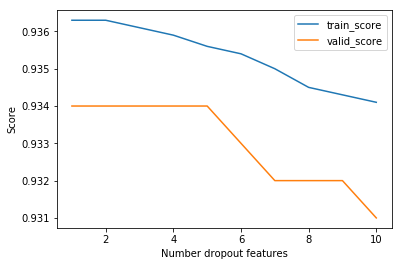

In [62]:
plt.plot(list_n, scores, label='train_score')
plt.plot(list_n, scores_valid, label='valid_score')
plt.xlabel(xlabel = 'Number dropout features')
plt.ylabel(ylabel = 'Score')
plt.legend()

In [52]:
k = 0 # подсчитаем количество сайтов, которые встретились только 1, 2 или 3 раза
for i in range (0, len(L_new_zero)):
    if list(L_new_zero.items())[i][1][1] < 4:
        k+=1
        
k

27470

#### Вывод: на графике точка 5 - переломный момент, после которого качество модели начинает ухудшаться. Т.е. без потери качества мы можем избавиться от сайтов, которые встречаются 1, 2 или 3 раза и это позволит сократить пространство признаков на 27470 шт. в сравнении с исходной моделью.

### 1.7. Проверим качество на лидерборде, после того как избавимся от сайтов, которые встречаются 1,2 или 3 раза

In [77]:
def apply_boundaries(dict_n, n):
    L_new_zero = pickle.load(open(os.path.join(PATH_TO_DATA, 'L_new_zero.pkl'), 'rb')) # исходный словарь
    L_n = dict_n(L_new_zero, n)
    L_n_short = short_dict(L_n)
    X_init = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_without_www.pkl'), 'rb')) # исходный словарь
    train_test_new_names = apply_dict(X_init, L_n_short)
    train_test_sparse = to_sparse_matrix(train_test_new_names, L_n_short)
    X_train_sparse = train_test_sparse[:train_df.shape[0]]
    X_test_sparse = train_test_sparse[train_df.shape[0]:]
    score = cross_val_score(estimator=sgd_logit, X=X_train_sparse, y=y, cv=skf, scoring='roc_auc').mean()
    sgd_logit.fit(X_train_sparse, y)
    logit_test_pred_proba = sgd_logit.predict_proba(X_test_sparse)
    return (round(score, 4), logit_test_pred_proba)

In [78]:
score_lb, pred_lb = apply_boundaries(dict_without_n_lb, 4)

In [79]:
score_lb

0.9359

In [59]:
write_to_submission_file(pred_lb[:,1], 'Alice6') # -4

#### Качество на лидерборде - 0.91253. Предположение о том, что мы можем безболезненно избавиться от этих сайтов, подтвердилось

### 1.8. Попробуем избавиться от сайтов, которые встречаются очень часто

#### Посмотрим на частоты сайтов

In [59]:
AA = []
for i in range (0, len(L_12)):
    AA.append(list(L_12.items())[i][1][1])

In [60]:
len(AA)

47135

In [70]:
max(AA)

168150

In [71]:
AA # Отсортированный список с частотами сайтов

[168150,
 162411,
 112349,
 108810,
 75913,
 73867,
 64007,
 61699,
 51352,
 46423,
 45652,
 45308,
 38593,
 35231,
 33197,
 32409,
 31452,
 30826,
 29471,
 27629,
 25141,
 23570,
 22737,
 22090,
 20828,
 19651,
 18398,
 17322,
 16988,
 16826,
 16773,
 14756,
 14664,
 13764,
 13393,
 13320,
 13271,
 12441,
 12206,
 11865,
 11865,
 11797,
 11508,
 11480,
 11410,
 11221,
 11118,
 11100,
 11017,
 11002,
 10585,
 10476,
 10376,
 10195,
 10088,
 9913,
 9675,
 9395,
 8644,
 8546,
 8080,
 8064,
 8014,
 7798,
 7680,
 7635,
 7616,
 7307,
 7008,
 6969,
 6797,
 6780,
 6777,
 6756,
 6586,
 6290,
 6269,
 6194,
 6164,
 6113,
 6067,
 6037,
 6004,
 5690,
 5550,
 5540,
 5398,
 5389,
 5256,
 5142,
 5095,
 5071,
 5068,
 5058,
 4934,
 4931,
 4873,
 4722,
 4548,
 4437,
 4405,
 4354,
 4337,
 4218,
 4197,
 4172,
 4150,
 4133,
 4119,
 4086,
 4053,
 4025,
 4017,
 4012,
 4009,
 3777,
 3756,
 3714,
 3625,
 3612,
 3539,
 3533,
 3526,
 3472,
 3468,
 3464,
 3404,
 3381,
 3347,
 3213,
 3052,
 2976,
 2968,
 2959,
 29

In [64]:
def dict_without_n_ub(L, n): # в значениях словаря уберем сайты, которые встречаются больше, чем n раз
    L_new = {}
    for k, v in L.items():
        if v[1] < n:
            L_new[k] = v
        else:
            L_new[k] = [0, v[1]]
    return L_new

In [72]:
list_n_ub = [200000, 100000, 90000, 80000, 70000, 60000, 50000]
scores_ub, scores_valid_ub = feats_extract (list_n_ub, dict_without_n_ub)

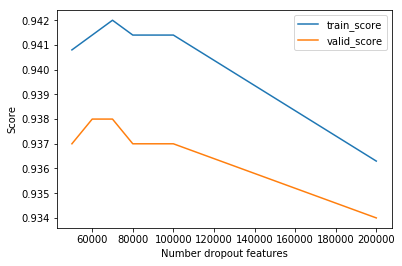

In [73]:
plt.plot(list_n_ub, scores_ub, label='train_score')
plt.plot(list_n_ub, scores_valid_ub, label='valid_score')
plt.xlabel(xlabel = 'Number dropout features')
plt.ylabel(ylabel = 'Score')
plt.legend()

In [74]:
scores_ub

[0.9363, 0.9414, 0.9414, 0.9414, 0.942, 0.9414, 0.9408]

In [83]:
np.array(scores_ub) - np.array(scores_valid_ub)

array([0.0023, 0.0044, 0.0044, 0.0044, 0.004 , 0.0034, 0.0038])

#### Очевидно, что при ограничении частоты сайтов сверху качество модели будет ухудшаться, т.к. разница ROC AUC на обучении и валидации увеличивается. Проверим оценку на лидерборде

In [80]:
score_ub, pred_ub = apply_boundaries(dict_without_n_ub, 100000)

In [81]:
score_ub

0.9414

In [82]:
write_to_submission_file(pred_ub[:,1], 'Alice8') # -100000

#### Качество на лидерборде - 0.90819. Качество действительно падает при ограничении частоты сайтов сверху

### На дынный момент окончательный вариант - ограничение частоты посещения сайтов снизу на уровне 4. Сохраним этот dataFrame

In [175]:
L_new_zero = pickle.load(open(os.path.join(PATH_TO_DATA, 'L_new_zero.pkl'), 'rb')) # исходный словарь
L_n = dict_without_n_lb(L_new_zero, 4)
L_n_short = short_dict(L_n)
X_init = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_without_www.pkl'), 'rb')) # исходный словарь
train_test_new_names = apply_dict(X_init, L_n_short)
train_test_sparse = to_sparse_matrix(train_test_new_names, L_n_short)
X_train_sparse = train_test_sparse[:train_df.shape[0]]
X_test_sparse = train_test_sparse[train_df.shape[0]:]

In [176]:
with open(os.path.join(PATH_TO_DATA, 'train_test_new_names4.pkl'), 'wb') as train_test_new_names4_pkl:
    pickle.dump(train_test_new_names, train_test_new_names4_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_train_sparse4.pkl'), 'wb') as X_train_sparse4_pkl:
    pickle.dump(X_train_sparse, X_train_sparse4_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_sparse4.pkl'), 'wb') as X_test_sparse4_pkl:
    pickle.dump(X_test_sparse, X_test_sparse4_pkl, protocol=2)

### 1.9. Попробуем CountVectirizer b TFIDFVectorizer с разным количеством n-грамм

In [128]:
train_test_new_names = pickle.load(open(os.path.join(PATH_TO_DATA, 'train_test_new_names4.pkl'), 'rb'))

In [93]:
def join_columns(data):    # соединим все столбы через запятую, чтобы использовать vctorizer
    data = pd.DataFrame(data, dtype = str)
    combined = (data['site' + str(1)] + ',')
    for i in range (2, 11):
        combined += (data['site' + str(i)] + ',')
    return combined

In [65]:
train_test_new_names = train_test_new_names.reset_index(drop = True)
train_test_new_names.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
0,583,0,0,0,0,0,0,0,0,0
1,154,36,169,36,43,187,169,187,239,243
2,364,15,188,364,17,15,188,188,188,188
3,3,3,3,3,3,3,3,3,3,3
4,4,33,32,53,33,53,32,33,33,53


In [114]:
combo_train = join_columns(train_test_new_names[:train_df.shape[0]])
#combo_valid = join_columns(train_test_new_names[train_share:train_df.shape[0]])
combo_test = join_columns(train_test_new_names[train_df.shape[0]:])

In [98]:
def Tf_IdfVector(train):
    columns = []
    score = []
    for i in ((1, 1), (1, 2), (1, 3), (1, 4)):
        TF = TfidfVectorizer(ngram_range= i)
        X = TF.fit_transform(train)
        #V = TF.transform(valid)
        #model = SGDClassifier(loss = 'log', random_state=17, n_jobs=-1).fit(X, y)
        #pred = model.predict_proba(V)
        score.append(round(cross_val_score(estimator=sgd_logit, X=X, y=y, cv=skf, scoring='roc_auc').mean(), 3))
        columns.append('n_gram = ' + str(i))
    frame = pd.DataFrame(data = np.array([score]), columns = columns)
    return frame

In [99]:
table_TF = Tf_IdfVector(combo_train)

In [100]:
table_TF # качество на обучении при использовании TfidfVectorizer

,"n_gram = (1, 1)","n_gram = (1, 2)","n_gram = (1, 3)","n_gram = (1, 4)"
0,0.915,0.912,0.91,0.908


#### Вывод - оценка ROC AUC при использовании TfidfVectorizer значительно ниже, чем при использовании первоначальной кодировки по частотам вхождения

#### Теперь попробуем CountVectorizer, здесь еще посмотрим на качество модели на валидации

In [110]:
combo_train2 = join_columns(train_test_new_names[:train_share])
combo_valid = join_columns(train_test_new_names[train_share:train_df.shape[0]])
combo_test = join_columns(train_test_new_names[train_df.shape[0]:])

In [105]:
def countVector(train, valid):
    columns = []
    score = []
    score_v = []
    for i in ((1, 1), (1, 2), (1, 3), (1, 4)):
        countV = CountVectorizer(ngram_range= i)
        X = countV.fit_transform(train)
        V = countV.transform(valid)
        model = SGDClassifier(loss = 'log', random_state=17, n_jobs=-1).fit(X, y_train)
        pred = model.predict_proba(V)
        score.append(round(cross_val_score(estimator=sgd_logit, X=X, y=y_train, cv=skf, scoring='roc_auc').mean(), 3))
        score_v.append(round(roc_auc_score(y_valid, pred[:, 1]), 3))
        columns.append('n_gram = ' + str(i))
    frame = pd.DataFrame(data = np.array([score]), columns = columns)
    return frame, score, score_v

In [111]:
table_Count, score, score_v = countVector(combo_train2, combo_valid)

In [112]:
table_Count

,"n_gram = (1, 1)","n_gram = (1, 2)","n_gram = (1, 3)","n_gram = (1, 4)"
0,0.94,0.945,0.943,0.943


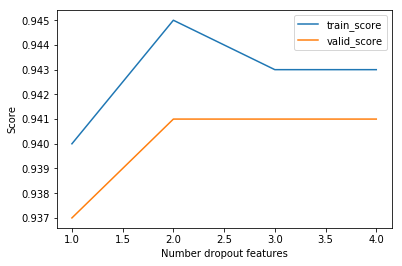

In [113]:
plt.plot([1, 2, 3, 4], score, label='train_score')
plt.plot([1, 2, 3, 4], score_v, label='valid_score')
plt.xlabel(xlabel = 'Number dropout features')
plt.ylabel(ylabel = 'Score')
plt.legend()

In [115]:
countV = CountVectorizer(ngram_range= (1, 1))
X = countV.fit_transform(combo_train)
Test = countV.transform(combo_test)
sgd_logit.fit(X, y)
logit_test_pred_proba = sgd_logit.predict_proba(Test)

In [116]:
write_to_submission_file(logit_test_pred_proba[:,1], 'Alice9') # CountV

#### Качество на лидерборде - 0.90247. Надежды не оправдались, поэтому дальше будем работать с датасетом, у которого уменьшили признаковое пространство на количество сайтов, посещенных менее 4 раз

### 2. Добавление признаков

In [300]:
X_train_sparse = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_train_sparse4.pkl'), 'rb'))
X_test_sparse = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_test_sparse4.pkl'), 'rb'))

### 2.1. Загрузим предподготовленные в отдельном файле признаки и посмотрим, что у нас есть

In [43]:
feats_numeric = pickle.load(open(os.path.join(PATH_TO_DATA, 'feats_numeric.pkl'), 'rb'))
new_feats2 = pickle.load(open(os.path.join(PATH_TO_DATA, 'new_feats2.pkl'), 'rb'))
data_delta = pickle.load(open(os.path.join(PATH_TO_DATA, 'data_delta.pkl'), 'rb'))
freq_sites_full_30 = pickle.load(open(os.path.join(PATH_TO_DATA, 'freq_sites_full_30.pkl'), 'rb'))

#### Длина сессии, количество сайтов из топ-30, время проведенное на сайтах из топ-30 и кол-во уникальных сайтов в сессии:

In [44]:
feats_numeric.head()

,session_timespan,event_30,time_top30,unique
0,0,0,0,1
1,26,0,0,7
2,7,3,2,4
3,270,10,270,1
4,246,1,137,4


#### Месяц, день и час начала сессии и некоторые связанные с ними бинарные признаки:

In [45]:
new_feats2.head()

,start_month,start_hour,day_of_week,is_work_day,is_holiday,is_morning,is_midday,is_after_midday,is_evening,is_night,is_winter,is_spring,is_summer,is_autumn
0,2,10,3,1,0,1,0,0,0,0,1,0,0,0
1,2,11,5,0,1,0,1,0,0,0,1,0,0,0
2,12,16,0,1,0,0,0,1,0,0,1,0,0,0
3,3,10,4,1,0,1,0,0,0,0,0,1,0,0
4,2,10,4,1,0,1,0,0,0,0,1,0,0,0


#### Время, проведенное на каждом сайте:

In [46]:
data_delta.head()

,delta_time1,delta_time2,delta_time3,delta_time4,delta_time5,delta_time6,delta_time7,delta_time8,delta_time9
0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,23,1
2,1,1,0,0,0,1,1,1,2
3,30,30,30,30,30,30,30,30,30
4,137,0,1,0,36,0,0,67,5


#### Частота посещения сайтов из топ-30 тех, которые нравятся Элис:

In [47]:
freq_sites_full_30.head()

,google.com,google.fr,Unknown.Unknown,facebook.com,nih.gov,annotathon.org,youtube.com,bing.com,live.com,twitter.com,...,geotrust.com,wikipedia.org,baidu.com,msn.com,ac.uk,verisign.com,jboss.org,cloudfront.net,openclassrooms.com,cedexis.com
0,0,0,9,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,10,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,0,0,0,0,0,0


### 2.2. Сформируем baseline

In [154]:
cat_columns = ['start_month', 'start_hour', 'day_of_week']

In [155]:
X = new_feats2[cat_columns]
X_add = pd.get_dummies(X, columns=X.columns)

In [156]:
X_train = hstack([X_train_sparse, X_add[:train_df.shape[0]]])
X_test = hstack([X_test_sparse, X_add[train_df.shape[0]:]])

In [157]:
score = cross_val_score(estimator=sgd_logit, X=X_train, y=y, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', round(score, 4))

ROC AUC score:  0.9772


In [52]:
sgd_logit.fit(X_train, y)
sgd_logit_test_pred_proba = sgd_logit.predict_proba(X_test)

In [53]:
write_to_submission_file(sgd_logit_test_pred_proba[:,1], 'Alice8')

#### Качество на лидерборде - 0.93354.  Бенчмарк "Logit +3 features" побит

In [158]:
logit = LogisticRegression(n_jobs=-1, random_state=42)

In [159]:
score = cross_val_score(estimator=logit, X=X_train, y=y, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', round(score, 4))

ROC AUC score:  0.9883


In [160]:
with open(os.path.join(PATH_TO_DATA, 'X_train_base.pkl'), 'wb') as X_train_base_pkl:
    pickle.dump(X_train, X_train_base_pkl, protocol=2)
with open(os.path.join(PATH_TO_DATA, 'X_test_base.pkl'), 'wb') as X_test_base_pkl:
    pickle.dump(X_test, X_test_base_pkl, protocol=2)

In [56]:
logit.fit(X_train, y)
logit_test_pred_proba2 = logit.predict_proba(X_test)

In [195]:
write_to_submission_file(logit_test_pred_proba2[:,1], 'Alice9')

#### Качество на лидерборде - 0.94552. Примем этот уровень за некоторый baseline. Дальше будем использовать Логистическую регрессию и попробуем улучшить этот результат

### 2.3. Попробуем добавить еще признаков

In [57]:
combine_feats = pd.DataFrame() # добавим комбинированные признаки
combine_feats['feat1'] = feats_numeric['time_top30'] / feats_numeric['session_timespan']
combine_feats['feat2'] = feats_numeric['event_30'] / feats_numeric['unique']
combine_feats['feat3'] = feats_numeric['time_top30'] / feats_numeric['event_30']
combine_feats = combine_feats.fillna(0)

In [135]:
numeric_feats = pd.concat([#freq_sites_full_30, 
                           feats_numeric, 
                           data_delta, 
                           #combine_feats
                          ], axis=1, sort=False)
#numeric_feats = numeric_feats.drop(['google.com'], axis = 1)

In [136]:
numeric_feats.head(2)

,session_timespan,event_30,time_top30,unique,delta_time1,delta_time2,delta_time3,delta_time4,delta_time5,delta_time6,delta_time7,delta_time8,delta_time9
0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,26,0,0,7,0,1,0,0,0,1,0,23,1


In [137]:
cat_columns = ['start_month', 'start_hour', 'day_of_week']

In [138]:
cat_feats = new_feats2[cat_columns]
numeric_feats = pd.concat([new_feats2[cat_columns], 
                           freq_sites_full_30, 
                           #data_delta, 
                           #combine_feats
                          ], axis=1, sort=False)

In [139]:
bin_feats = new_feats2.drop(['start_month', 'start_hour', 'day_of_week', 'is_night'], axis = 1)

In [140]:
bin_feats.head(2)

,is_work_day,is_holiday,is_morning,is_midday,is_after_midday,is_evening,is_winter,is_spring,is_summer,is_autumn
0,1,0,1,0,0,0,1,0,0,0
1,0,1,0,1,0,0,1,0,0,0


In [141]:
print(len(numeric_feats), len(cat_feats), len(bin_feats))

336358 336358 336358


In [142]:
full_data = pd.concat([numeric_feats, cat_feats, bin_feats], axis=1, sort=False)

In [143]:
full_data.shape

(336358, 46)

In [144]:
full_data.isnull().values.any()

False

In [145]:
binary_data_columns = list(bin_feats.columns)
binary_data_indices = np.array([(column in binary_data_columns) for column in full_data.columns], dtype = bool)

In [146]:
categorical_data_columns = list(cat_feats.columns)
categorical_data_indices = np.array([(column in categorical_data_columns) for column in full_data.columns], dtype = bool)

In [147]:
numeric_data_columns = list(numeric_feats.columns)
numeric_data_indices = np.array([(column in numeric_data_columns) for column in full_data.columns], dtype = bool)

In [85]:
from sklearn import pipeline
from sklearn import preprocessing

#### Сделаем pipeline для автоматической обработки и соединения новых признаков

In [148]:
estimator = pipeline.Pipeline(steps = [       
    ('feature_processing', pipeline.FeatureUnion(transformer_list = [
            #binary
            ('binary_variables_processing', preprocessing.FunctionTransformer(lambda data: data[:, binary_data_indices])),        
            #numeric
            ('numeric_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, numeric_data_indices])),
                ('scaling', preprocessing.StandardScaler(with_mean = 0))            
                        ])),
        
            #categorical
            ('categorical_variables_processing', pipeline.Pipeline(steps = [
                ('selecting', preprocessing.FunctionTransformer(lambda data: data[:, categorical_data_indices])),
                ('hot_encoding', preprocessing.OneHotEncoder(handle_unknown = 'ignore'))            
                        ])),
             ]))
    #('model_fitting', regressor)
    ]
)

In [117]:
def full_transform(data):
    feats_part1 = estimator.fit_transform(data)
    feats_part2 = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_train_sparse4.pkl'), 'rb'))
    feats_part3 = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_test_sparse4.pkl'), 'rb'))
    full_train = hstack([feats_part1[:train_df.shape[0]], feats_part2])
    full_test = hstack([feats_part1[train_df.shape[0]:], feats_part3])
    #X = hstack([feats_part1, feats_part2])
    #part = train_df.shape[0] - 10000
    #train_valid = hstack([feats_part1[:part], feats_part2[:part]])
    #valid = hstack([feats_part1[part:train_df.shape[0]], feats_part2[part:train_df.shape[0]]])
    return full_train, full_test#, feats_part1, feats_part2#, X

In [149]:
full_train, full_test = full_transform(full_data)

In [245]:
score = cross_val_score(estimator=logit, X=full_train, y=y, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', round(score, 4))

ROC AUC score:  0.9889


In [151]:
logit = LogisticRegression(n_jobs=-1, random_state=42)
logit.fit(full_train, y)
logit_test_pred = logit.predict_proba(full_test)

In [152]:
write_to_submission_file(logit_test_pred[:,1], 'Alice10')

#### Качество на лидерборде - 0.94496. Данными признаками значительного улучшения добиться также не удалось

### 2.4. Попробуем настроить параметры логистической регрессии

In [311]:
X_train = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_train_base.pkl'), 'rb'))
X_test = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_test_base.pkl'), 'rb'))

In [164]:
from sklearn.model_selection import GridSearchCV

In [165]:
logit.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [166]:
parameters_grid = {
    'C' : np.linspace(0.1, 10, num = 10)
}

In [167]:
grid_cv = GridSearchCV(logit, parameters_grid, scoring = 'roc_auc', cv = skf)

In [168]:
grid_cv.fit(X_train, y)

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=42, shuffle=True),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': array([ 0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

In [169]:
print (grid_cv.best_score_)
print (grid_cv.best_params_)

0.9889364828581061
{'C': 3.4000000000000004}


In [170]:
logit_grid = LogisticRegression(C = 3.4, n_jobs=-1, random_state=42)

In [173]:
score = cross_val_score(estimator=logit_grid, X=full_train, y=y, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', round(score, 4))

ROC AUC score:  0.9895


#### Результат впечатляет, но лучше оценить кривую обучения/валидации

In [285]:
train_share = int(.7 * X_train_sparse.shape[0])

In [332]:
def check_grid(data_train):
    score = []
    score_valid = []
    C_list = np.linspace(0.1, 10, num = 10)
    X_train, y_train = data_train.tocsr()[:train_share, :], y[:train_share]
    X_valid, y_valid  = data_train.tocsr()[train_share:, :], y[train_share:]
    for C in C_list:
        logit_grid = LogisticRegression(C = C, n_jobs=-1, random_state=42)
        score.append(cross_val_score(estimator=logit_grid, X=data_train, y=y, cv=skf, scoring='roc_auc').mean())
        logit_grid.fit(X_train, y_train)
        logit_test_pred_proba = logit_grid.predict_proba(X_valid)
        score_valid.append(roc_auc_score(y_valid, logit_test_pred_proba[:,1]))
    return (score, score_valid)

In [333]:
score, score_valid = check_grid(X_train)

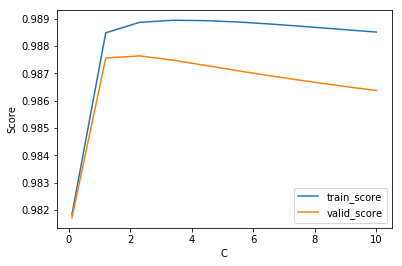

In [335]:
C_list = np.linspace(0.1, 10, num = 10)
plt.plot(C_list, score, label='train_score')
plt.plot(C_list, score_valid, label='valid_score')
plt.xlabel(xlabel = 'C')
plt.ylabel(ylabel = 'Score')
plt.legend()

#### Вывод - после значения С = 1 качество модели на отложенной выборке существенно начинает уменьшаться. Видимо, вариант с настройкой гиперпараметров в этом случае большого улучшения не даст

### 3. Попробуем ансамбль методов для создания метапризнаков

In [258]:
X_train_sparse = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_train_base.pkl'), 'rb'))
X_test_sparse = pickle.load(open(os.path.join(PATH_TO_DATA, 'X_test_base.pkl'), 'rb'))
y = pickle.load(open(os.path.join(PATH_TO_DATA, 'y_train.pkl'), 'rb')) 

In [177]:
clfs = [LogisticRegression(n_jobs=-1, random_state=42),
        ComplementNB(), BernoulliNB(alpha=.1), MultinomialNB(alpha=1.0),
       SVC(C = 1, random_state=17, probability = True),
       RandomForestClassifier(n_estimators=100, n_jobs=-1, criterion='gini'),
       ExtraTreesClassifier(n_estimators=100, n_jobs=-1, criterion='entropy'),
       GradientBoostingClassifier(learning_rate=0.05, subsample=0.8, n_estimators=100)]

In [178]:
dataset_stack_train = np.zeros((X_train.shape[0], len(clfs)))
dataset_stack_test = np.zeros((X_test.shape[0], len(clfs)))
dataset_stack_test_j = np.zeros((X_test.shape[0], 5))

In [217]:
skf1 = StratifiedKFold(n_splits=5)

In [224]:
# Обобщим на несколько алгоритмов
def stack(clfs):
    for j, clf in enumerate(clfs):
        print (j, clf)    
        for i, (train, val) in enumerate(skf1.split(X_train_sparse, y)):
            print("Fold:", i)
            X_tr = X_train_sparse.tocsr()[train]
            X_val = X_train_sparse.tocsr()[val]
            #print(X_tr.shape, X_val.shape)
            y_tr = y[train]
            y_val = y[val]
            clf.fit(X_tr, y_tr)

            pred_val = clf.predict_proba(X_val)[:, 1]
            dataset_stack_train[val, j] = pred_val

            dataset_stack_test_j[:, i] = clf.predict_proba(X_test_sparse)[:, 1]

        dataset_stack_test[:, j] = dataset_stack_test_j.mean(1)
    return dataset_stack_train, dataset_stack_test

In [225]:
dataset_stack_train, dataset_stack_test = stack(clfs)

0 LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=42, solver='warn', tol=0.0001,
          verbose=0, warm_start=False)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
1 ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
2 BernoulliNB(alpha=0.1, binarize=0.0, class_prior=None, fit_prior=True)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
3 MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
4 SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=17,
  shrinking=True, tol=0.001, verbose=False)
Fold: 0
Fold: 1
Fold: 2
Fold: 3
Fold: 4
5 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth

In [226]:
dataset_stack_train.shape

(253561, 8)

#### Попробуем обучить логистическую регрессию только на данных метапризнаках

In [227]:
clf = LogisticRegression(n_jobs=-1, random_state=42)

In [255]:
score = cross_val_score(estimator=clf, X=dataset_stack_train, y=y, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', round(score, 4))

ROC AUC score:  0.9949


In [253]:
train_share = int(.7 * X_train_sparse.shape[0])
X_train, y_train = dataset_stack_train[:train_share, :], y[:train_share]
X_valid, y_valid  = dataset_stack_train[train_share:, :], y[train_share:]

In [254]:
clf.fit(X_train, y_train)
pred1 = clf.predict_proba(X_valid)[:, 1]
round(roc_auc_score(y_valid, pred1), 3)

0.992

#### Результат неплохой, посмотрим на качество на лидерборде

In [230]:
clf.fit(dataset_stack_train, y)
y_submission = clf.predict_proba(dataset_stack_test)[:, 1]

In [234]:
y_submission

array([0.00083426, 0.00080935, 0.00080934, ..., 0.00081566, 0.00080941,
       0.00080935])

In [235]:
write_to_submission_file(y_submission, 'Alice11')

#### Качество на лидерборде - 0.91373.
#### Попробуем теперь данные метапризнаки добавить к имеющейся обучающей выборке

In [273]:
X_full_train = hstack([X_train_sparse, dataset_stack_train])
X_full_test = hstack([X_test_sparse, dataset_stack_test])

In [260]:
score = cross_val_score(estimator=clf, X=X_full_train, y=y, cv=skf, scoring='roc_auc').mean()
print('ROC AUC score: ', round(score, 4))

ROC AUC score:  0.9964


In [248]:
clf = LogisticRegression(n_jobs=-1, random_state=42)
clf.fit(X_full_train, y)
y_submission = clf.predict_proba(X_full_test)[:, 1]

In [256]:
y_submission

array([2.90735130e-05, 1.32867920e-07, 1.13056457e-07, ...,
       1.76227970e-04, 7.00498235e-06, 1.59926884e-08])

In [257]:
write_to_submission_file(y_submission, 'Alice11')

#### Качество на лидерборде - 0.94216. Значение ROC AUC близко к лучшему значению, которого удалось достичь. Однако, получается, что таким образом качество ансамбля близко, но не превосходит качества лучшей модели.
#### При большем количестве времени на задачу можно было бы попробовать данные модели обучить на разных поднаборах признаков.

### Заключение. 
#### Еще было опробовано:
- блендинг ответов бустинга и логистической регрессии, 
- выделение главных компонент и обучение на них простой нейросети, 
- различные кодировки категориальных признаков (Mean_encoding withot regularization, Smoothing regularization, Expanding regularization) - данные методы с имеющимся набором признаков так и не помогли значительно повысить оценку на лидерборде. Вероятнее всего, самый эффективный способ в данной задаче - генерация большего количества вариативных признаков.
## Сдаю эту задачу с окончательной оценкой на лидерборде - 0.94698, позиция - 1403, ID на Kaggle - Elena Margatckaia.

## Критерии оценки работы (только для Peer Review в специализации):
- Правильные ли получились размерности матриц в п. 1? (max. 2 балла)
- Правильным ли получилось значения ROC AUC в п. 2? (max. 4 балла)
- Побит ли бенчмарк "sgd_logit_benchmark.csv" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)
- Побит ли бенчмарк "Logit +3 features" на публичной части рейтинга в соревновании Kaggle? (max. 2 балла)

## Пути улучшения
На этой неделе дается много времени на соревнование. Не забывайте вносить хорошие идеи, к которым Вы пришли по ходу соревнования, в описание финального проекта (`html`, `pdf` или `ipynb`). Это только в случае, если вы проходите специализацию.
Что можно попробовать:
 - Использовать ранее построенные признаки для улучшения модели (проверить их можно на меньшей выборке по 150 пользователям, отделив одного из пользователей от остальных – это быстрее)
 - Настроить параметры моделей (например, коэффициенты регуляризации)
 - Если позволяют мощности (или хватает терпения), можно попробовать смешивание (блендинг) ответов бустинга и линейной модели. [Вот](http://mlwave.com/kaggle-ensembling-guide/) один из самых известных тьюториалов по смешиванию ответов алгоритмов, также хороша [статья](https://alexanderdyakonov.wordpress.com/2017/03/10/cтекинг-stacking-и-блендинг-blending) Александра Дьяконова
 - Обратите внимание, что в соревновании также даны исходные данные о посещенных веб-страницах Элис и остальными 1557 пользователями (*train.zip*). По этим данным можно сформировать свою обучающую выборку. 

На 6 неделе мы пройдем большой тьюториал по Vowpal Wabbit и попробуем его в деле, на данных соревнования.